<a href="https://colab.research.google.com/github/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Model_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center><b><u>Model Planning</u></b></center> </h3>
<h4><center><b>Prepared By: Simranjeet Randhawa</b></center> </h4>
<h4><center><b>Student ID: 200412297</b></center> </h4>




<h3> <b> 1. Model Planning with Data Exploration </b> </h3>
<p align="justify">
Data Exploration is the phase where one tries to understand the data in hand and how the different variables interact between each other. In Machine Learning, Data Exploration always precede the creation of the predictive model as it allows us to come up with ideas in order to increase the models’ performances.
</p>

https://datastudio.google.com/reporting/4c1a8825-32ec-44ab-8c34-19e988839087

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

In [0]:
project_id = 'nyc-taxi-265120' 
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

<h3> <b> 2. Model Planning - Feature Engineering </b> </h3>
<p align="justify">
In model planning,the methods, techniques, and workflow is being determined. In this phase the data is explored to learn about the relationships between variables and subsequently selects key variables and the most suitable models.
</p>

In [0]:
query = """
SELECT  * FROM `hello.CombinedData`
"""
data = client.query(query).to_dataframe()

<b><u> 2019 Data </u><b>

<p align="justify"> Adding hour,day of the week, daynumber, min and max temp in the Data and scaling it so that it can be trained </p>

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp,
    wd.rain,
 td.pickups,
    ST_ASTEXT(points.p) AS P,
  FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by year,zone_id,time,daynumber,hour,pickups,P,dayofweek, mintemp, maxtemp, rain
"""
df2 = client.query(query).to_dataframe()

In [0]:
zone=df2[['zone_id', 'pickups']] 

In [0]:
zonewise_2019 = zone.groupby(['zone_id']).sum()

In [0]:
zonewise_2019.reset_index(inplace = True)

In [0]:
import plotly.express as px
configure_plotly_browser_state()

fig = px.bar( x=zonewise_2019['zone_id'], y=zonewise_2019['pickups'])
fig.update_layout(
    title="Which Zone id has highest number of pickups in 2019?",
    xaxis_title="Zone ID",
    yaxis_title="Pickups",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
pyo.iplot(fig)

In [0]:
daynumber=df2[['daynumber', 'pickups']] 

In [0]:
daynumber_2019 = daynumber.groupby(['daynumber']).sum()
daynumber_2019.reset_index(inplace = True)

In [0]:
import plotly.express as px
configure_plotly_browser_state()

fig = px.bar( x=daynumber_2019['daynumber'], y=daynumber_2019['pickups'])
fig.update_layout(
    title="How pickups changes Day by Day in 2019?",
    xaxis_title="Day Number",
    yaxis_title="Pickups",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
pyo.iplot(fig)

In [0]:
ans_2019=df2[['time','pickups']]

hourwise=ans_2019.groupby([ans_2019["time"].dt.year, ans_2019["time"].dt.hour]).mean()

In [0]:
hourwise.index.names = ["year", "hour"]
hourwise.reset_index(inplace = True)

In [0]:
import plotly.express as px
configure_plotly_browser_state()

fig1 = px.bar( x=hourwise['hour'], y=hourwise['pickups'])
fig1.update_layout(
    title="Average pickups Hour by Hour in 2019? (Considering all Zones)",
    xaxis_title="Hour",
    yaxis_title="Average Pickups",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

pyo.iplot(fig1)

<b><u> 2018 Data </u><b>

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2018`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp,
    wd.rain,
 td.pickups,
    ST_ASTEXT(points.p) AS P,
  FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by year,zone_id,time,daynumber,hour,pickups,P,dayofweek, mintemp, maxtemp, rain
"""
df_2018 = client.query(query).to_dataframe()

In [0]:
daynumber2018=df_2018[['daynumber', 'pickups']] 

In [0]:
daynumber_2018 = daynumber2018.groupby(['daynumber']).sum()


In [0]:
daynumber_2018.reset_index(inplace = True)

In [0]:
import plotly.express as px
configure_plotly_browser_state()

fig1 = px.bar( x=daynumber_2018['daynumber'], y=daynumber_2018['pickups'])
fig1.update_layout(
    title="How pickups changes Day by Day in 2018?",
    xaxis_title="Day Number",
    yaxis_title="Pickups",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

pyo.iplot(fig1)

import plotly.express as px
configure_plotly_browser_state()

fig = px.bar( x=daynumber_2019['daynumber'], y=daynumber_2019['pickups'])
fig.update_layout(
    title="How pickups changes Day by Day in 2019?",
    xaxis_title="Day Number",
    yaxis_title="Pickups",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
pyo.iplot(fig)

In [0]:
df_2018.head()

year zone_id  ... pickups                                          P
0  2018     235  ...     1.0  POINT(-73.9159758118083 40.8525209629819)
1  2018     235  ...     1.0  POINT(-73.9159758118083 40.8525209629819)
2  2018     235  ...     1.0  POINT(-73.9159758118083 40.8525209629819)
3  2018     235  ...     1.0  POINT(-73.9159758118083 40.8525209629819)
4  2018     235  ...     1.0  POINT(-73.9159758118083 40.8525209629819)

[5 rows x 11 columns]

In [0]:
ans=df_2018[['time','pickups']]
hourwise=ans.groupby([ans["time"].dt.year, ans["time"].dt.hour]).mean()

In [0]:
hourwise.index.names = ["year", "hour"]
hourwise.reset_index(inplace = True)

In [0]:
import plotly.express as px
configure_plotly_browser_state()

fig1 = px.bar( x=hourwise['hour'], y=hourwise['pickups'])
fig1.update_layout(
    title="Average pickups Hour by Hour in 2018? ( COnsidering all Zones)",
    xaxis_title="Hour",
    yaxis_title="Average Pickups",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

pyo.iplot(fig1)

<p align="justify"> By exploration, it can be said that the somefeatures to be considered for training a model are as follows:
<ol>
<li> Zone id: Zone id is a categorical variable and can be thus handled using the techinique of One Hot Encoding. </li>
<li> Hour of the day: As we say above that the rides drop between 1AM - 5AM. When it is 6AM the number of pickups increases and we expect the maximum pickups between 6 PM to 9PM. Hence it is also an important factor </li>
<li> Day of the week  </li></ol>
</p>


<p align="justify"> Creating Time features for the Model building</p>

In [0]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [0]:
import matplotlib.pyplot as plt # visualization
import seaborn as sns
data = pd.concat([hourwise['hour'], hourwise['pickups']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='hour', y='pickups', data=data, showfliers=False)


In [0]:
data_14 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_14, showfliers=False, hue='IsHoliday')

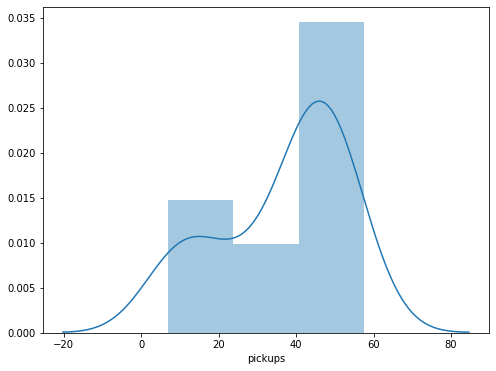

In [0]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(hourwise['pickups'])

<p align="justify"> Correlation Matrix:
Correlation is a bi-variate analysis that measures the strength of association between two variables and the direction of the relationship. In terms of the strength of relationship, the value of the correlation coefficient varies between +1 and -1.
A value of ± 1 indicates a perfect degree of association between the two variables. As the correlation coefficient value goes towards 0, the relationship between the two variables will be weaker. The direction of the relationship is indicated by the sign of the coefficient; a + sign indicates a positive relationship and a — sign indicates a negative relationship. Usually, in statistics, we measure four types of correlations: Pearson correlation, Kendall rank correlation, and Spearman correlation. The graph below will give you an idea about correlation.</p>

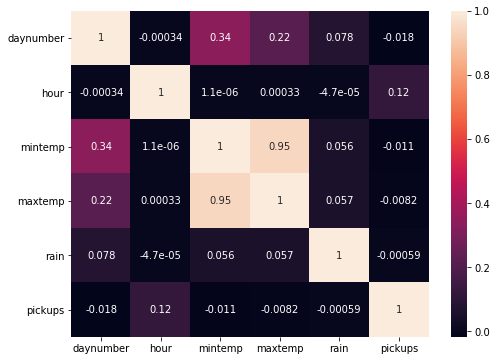

In [0]:
import seaborn as sns

import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 6))
corrMatrix = df_2018.corr()
sns.heatmap(corrMatrix, annot=True)


<p align="justify"> Forecasting pickups using Power BI </p>


<h3> 7. Model Building </h3>
<p align="justify">
 In this phase, I will develop datasets for training and testing purposes. Moreover I will consider whether your existing tools will suffice for running the models or it will need a more robust environment (like fast and parallel processing). I will analyse different models on the data and thereby choose the one with minimum mean square error and higher accuracy.
 </p>

In [0]:
#2018 DATA
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
       MIN(temp) temp,  MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2018`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
wd.temp,  wd.mintemp, 
wd.maxtemp,
wd.rain,
td.pickups,
ST_X(p) as longitude,
ST_Y(p) as latitude
FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
where wd.year = td.year AND
wd.daynumber = td.daynumber
group by year,zone_id,time,daynumber,hour,pickups,longitude,latitude,dayofweek, temp,mintemp, maxtemp, rain

"""
df1 = client.query(query).to_dataframe()


In [0]:
#2019 DATA
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(temp) temp,MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
wd.temp,
wd.mintemp, 
wd.maxtemp,
wd.rain,
td.pickups,

    ST_X(p) as longitude,
  ST_Y(p) as latitude
 
  FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by year,zone_id,time,daynumber,hour,pickups,longitude,latitude,dayofweek,temp, mintemp, maxtemp, rain

"""
df2 = client.query(query).to_dataframe()

In [0]:
#2019 DATA
query = """
SELECT  * from `hello.CombinedData`

"""
df2 = client.query(query).to_dataframe()

In [0]:
df1.head()

year zone_id                      time  ...  pickups  longitude   latitude
0  2018       7 2018-01-04 13:00:00+00:00  ...     14.0 -73.919694  40.761493
1  2018       7 2018-01-15 16:00:00+00:00  ...     14.0 -73.919694  40.761493
2  2018       7 2018-01-20 18:00:00+00:00  ...     14.0 -73.919694  40.761493
3  2018       7 2018-01-31 21:00:00+00:00  ...     14.0 -73.919694  40.761493
4  2018       7 2018-02-07 23:00:00+00:00  ...     14.0 -73.919694  40.761493

[5 rows x 13 columns]

In [0]:
df1groupby = df1[['zone_id','time','pickups']].groupby(['zone_id','time','pickups'])

In [0]:

len(df1.zone_id.unique())

259

In [0]:

len(df2.zone_id.unique())

258

In [0]:
data=df2

In [0]:
data["zone_id"] = data["zone_id"].astype(int)
data["dayofweek"] = data["dayofweek"].astype(int)

In [0]:

data.drop('P', axis=1, inplace=True)


In [0]:
import pandas as pd
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum() # Resmapling the time series data with month starting first.
# Train-Test splitting of time series data


In [0]:
data.head()

pickups
time                               
2018-01-01 00:00:00+00:00  231546.0
2018-01-02 00:00:00+00:00  233052.0
2018-01-03 00:00:00+00:00  261087.0
2018-01-04 00:00:00+00:00  119818.0
2018-01-05 00:00:00+00:00  259731.0

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


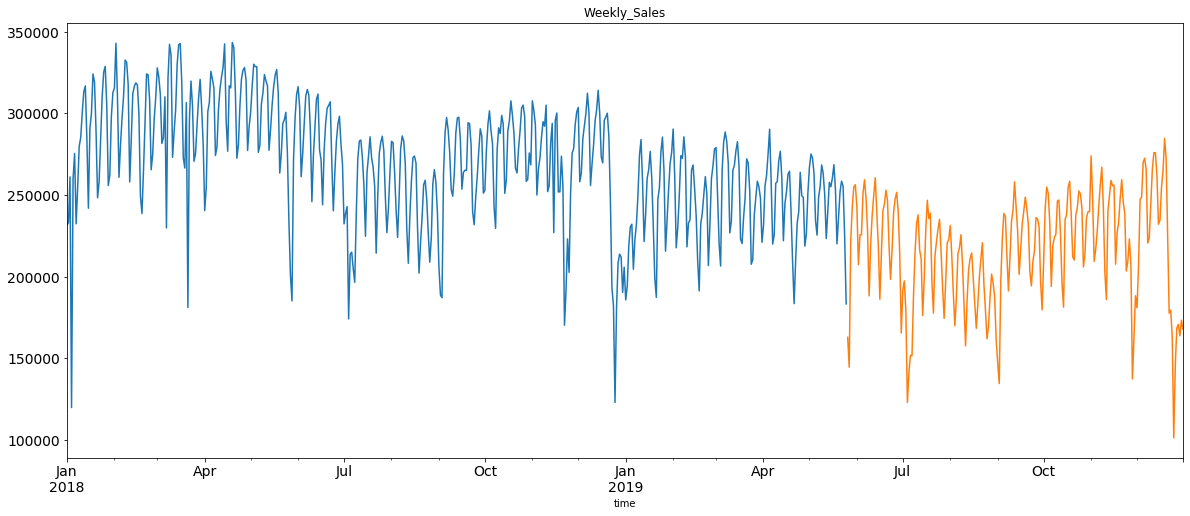

In [0]:
train_data = data[:int(0.7*(len(data)))]
test_data = data[int(0.7*(len(data))):]
# ARIMA takes univariate data.
train_data = train_data['pickups']
test_data = test_data['pickups']
# Plot of Weekly_Sales with respect to years in train and test.
train_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [0]:
data = data.fillna(method='ffill')

In [0]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['pickups'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.8620831215235754
p-value: 0.35010313377312674
Critical Values:
	1%: -3.439593802573824
	5%: -2.865619356068967
	10%: -2.568942332870462


In [0]:
!pip install pyramid-arima

In [0]:
# Applying auto_arima model on train data.
from pyramid.arima import auto_arima
model_auto_arima = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_arima = auto_arima(train_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,stepwise=False, suppress_warnings=True, D=1, max_D=10,error_action='ignore',approximation = False)
model_auto_arima.fit(train_data)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=216120.095, BIC=216164.581, Fit time=10.754 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=223114.395, BIC=223129.224, Fit time=0.415 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=217121.887, BIC=217144.130, Fit time=1.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=217173.200, BIC=217195.443, Fit time=2.037 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=216140.457, BIC=216177.529, Fit time=5.204 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=216054.012, BIC=216105.912, Fit time=11.592 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=216169.532, BIC=216214.018, Fit time=4.722 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=213524.367, BIC=213583.682, Fit time=35.523 seconds
Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=214609.706, BIC=214683.850, Fit time=33.353 secon

KeyboardInterrupt: ignored

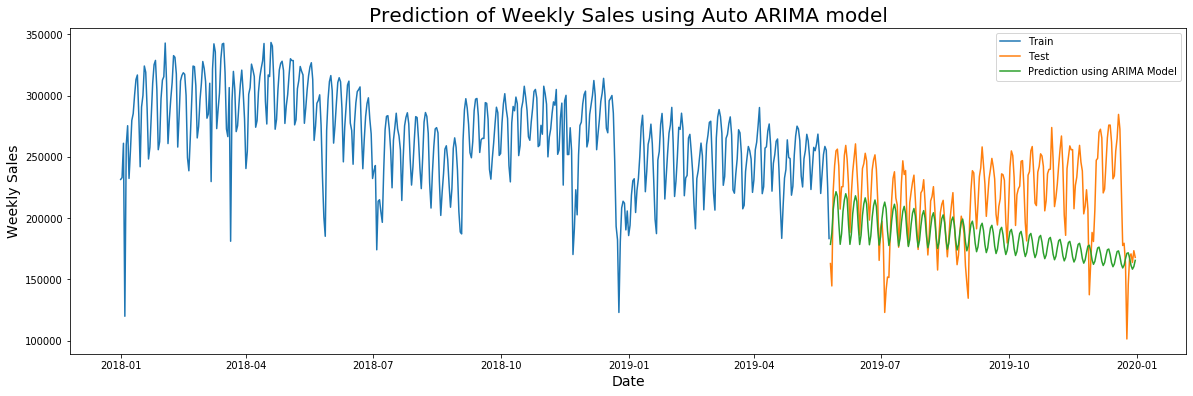

In [0]:
import matplotlib.pyplot as plt
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Pickups', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [0]:
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

In [0]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


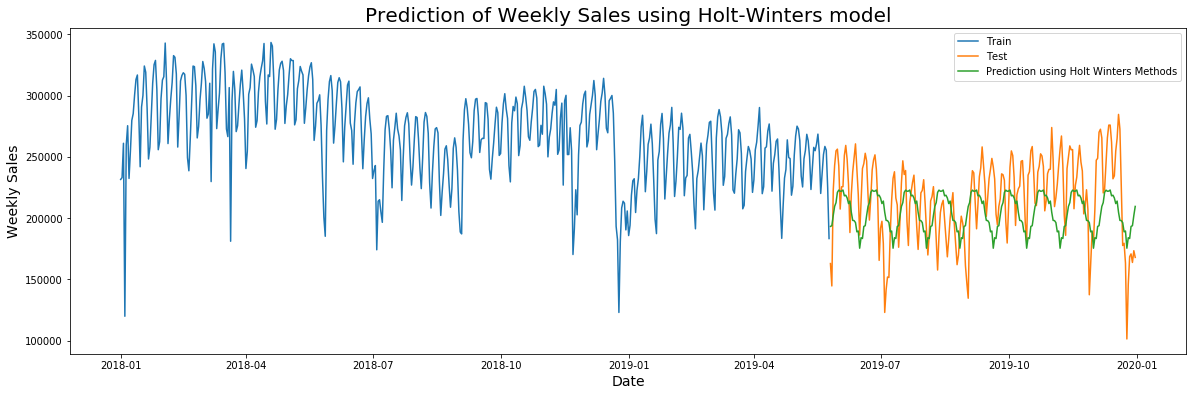

In [0]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=24, seasonal='additive' ).fit() 
pred = model_holt_winters.forecast(len(test_data))# Predict the test data
#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [0]:
print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test_data, pred))
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', math.sqrt(mean_squared_error(test_data, pred)))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

NameError: ignored

Trying

In [0]:
a=df2

In [0]:
a.head()

zone_id                      time  pickups
0       7 2018-01-01 13:00:00+00:00     14.0
1       7 2018-01-04 12:00:00+00:00     14.0
2       7 2018-01-04 13:00:00+00:00     14.0
3       7 2018-01-05 21:00:00+00:00     14.0
4       7 2018-01-06 13:00:00+00:00     14.0

In [0]:
data=df2

In [0]:
a=df2
a = a.resample('D').sum()
ts=a.groupby(["time"])["pickups"].sum()


In [0]:
df2=a.groupby(["time"])["pickups"].sum().reset_index()

 

                         time   pickups
0   2018-01-01 00:00:00+00:00  231546.0
1   2018-01-02 00:00:00+00:00  233052.0
2   2018-01-03 00:00:00+00:00  261087.0
3   2018-01-04 00:00:00+00:00  119818.0
4   2018-01-05 00:00:00+00:00  259731.0
..                        ...       ...
725 2019-12-27 00:00:00+00:00  168499.0
726 2019-12-28 00:00:00+00:00  170764.0
727 2019-12-29 00:00:00+00:00  163766.0
728 2019-12-30 00:00:00+00:00  173360.0
729 2019-12-31 00:00:00+00:00  167889.0

[730 rows x 2 columns]


In [0]:
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum()

In [0]:
data.head()

pickups
time                               
2018-01-01 00:00:00+00:00  231546.0
2018-01-02 00:00:00+00:00  233052.0
2018-01-03 00:00:00+00:00  261087.0
2018-01-04 00:00:00+00:00  119818.0
2018-01-05 00:00:00+00:00  259731.0

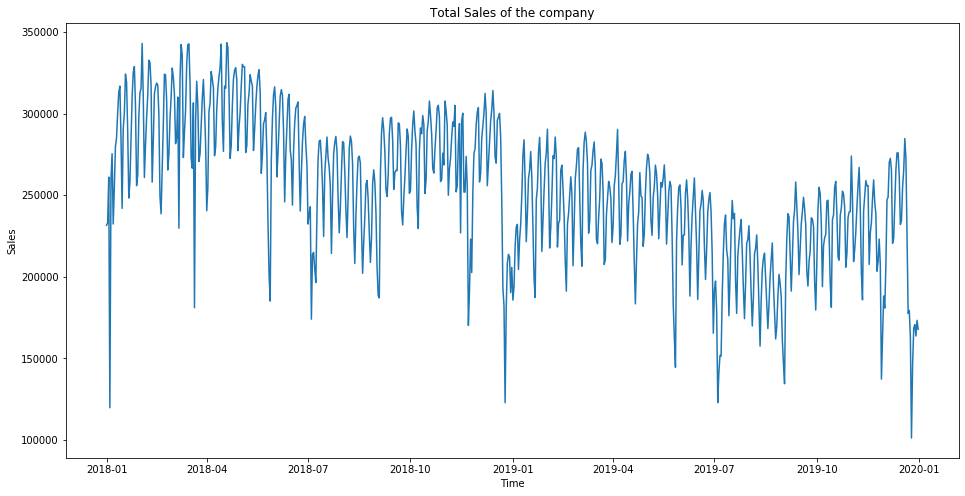

In [0]:
ts=data.groupby(["time"])["pickups"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

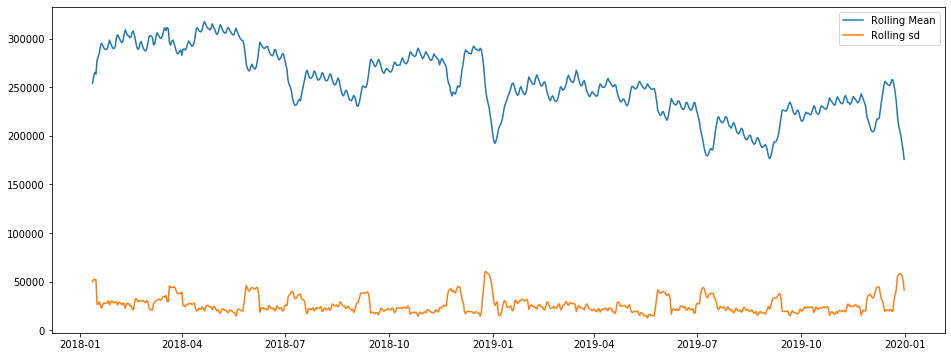

In [0]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

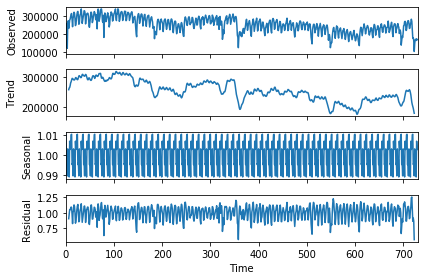

In [0]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

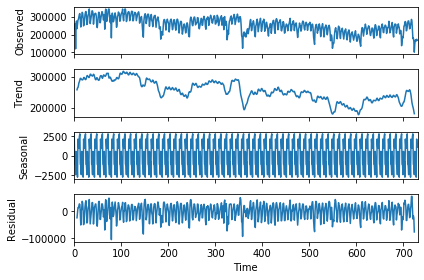

In [0]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [0]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.862083
p-value                          0.350103
#Lags Used                      19.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


In [0]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

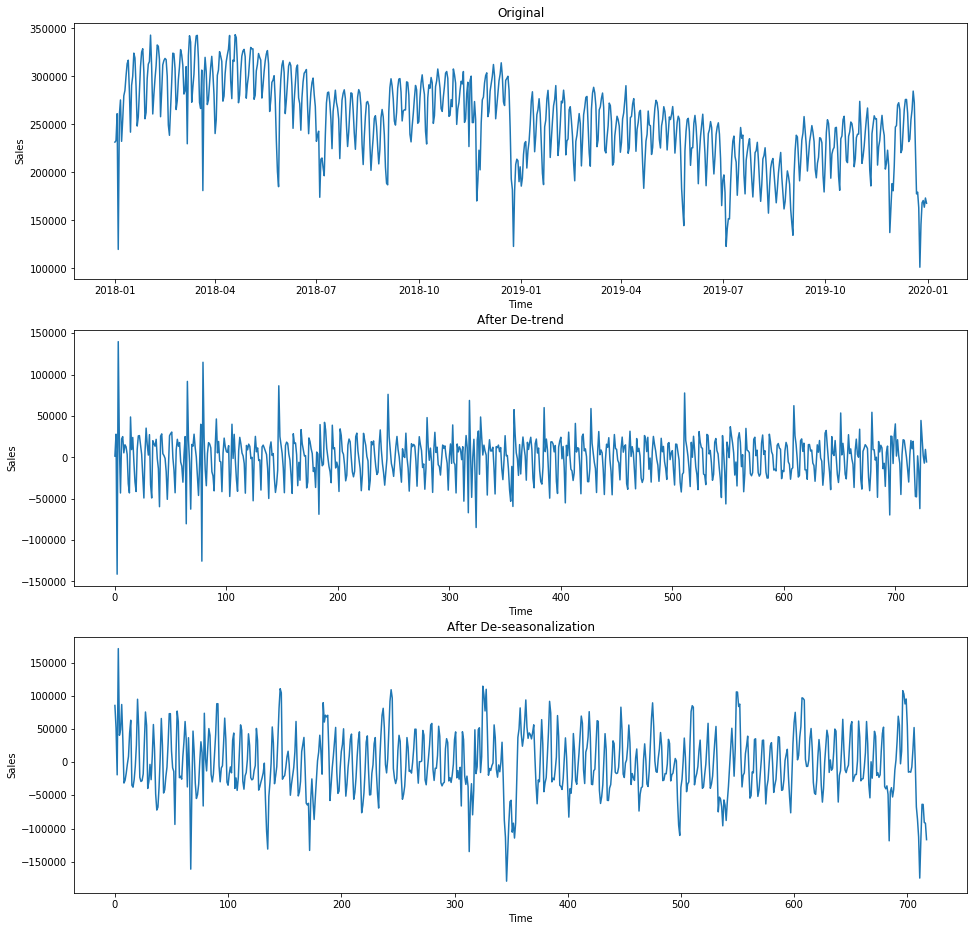

In [0]:
ts=data.groupby(["time"])["pickups"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [0]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -7.981551e+00
p-value                        2.615200e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.970000e+02
Critical Value (1%)           -3.439767e+00
Critical Value (5%)           -2.865696e+00
Critical Value (10%)          -2.568983e+00
dtype: float64


In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


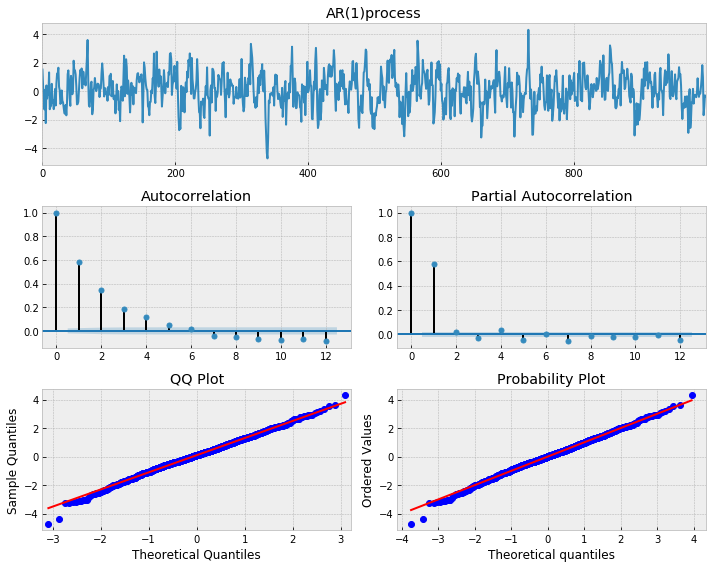

In [0]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

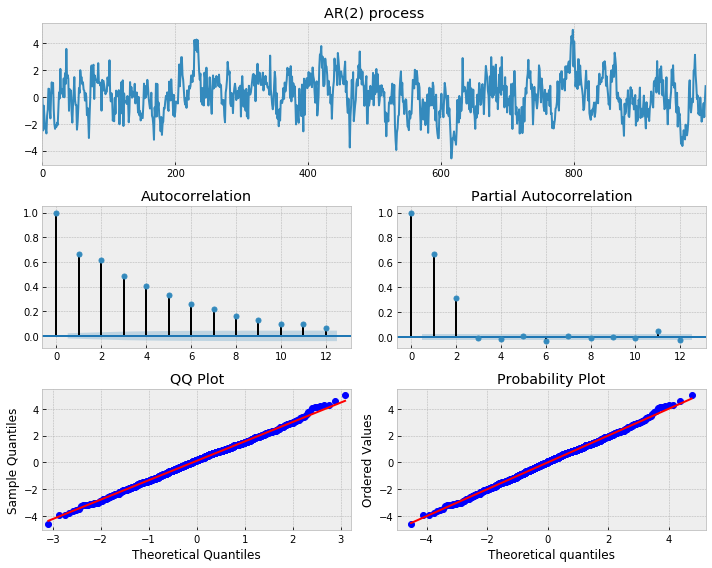

In [0]:
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

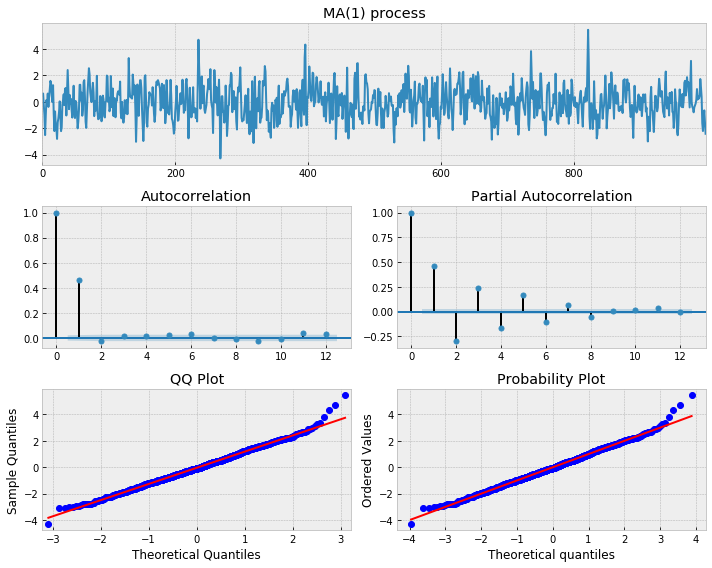

In [0]:
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

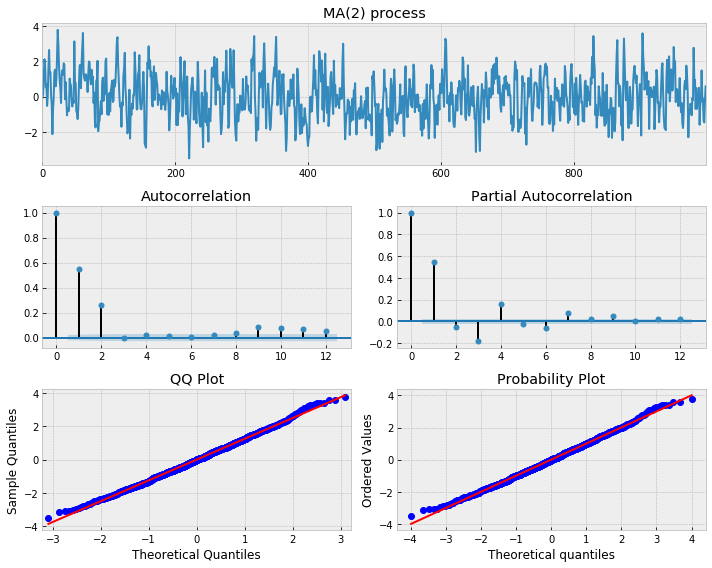

In [0]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

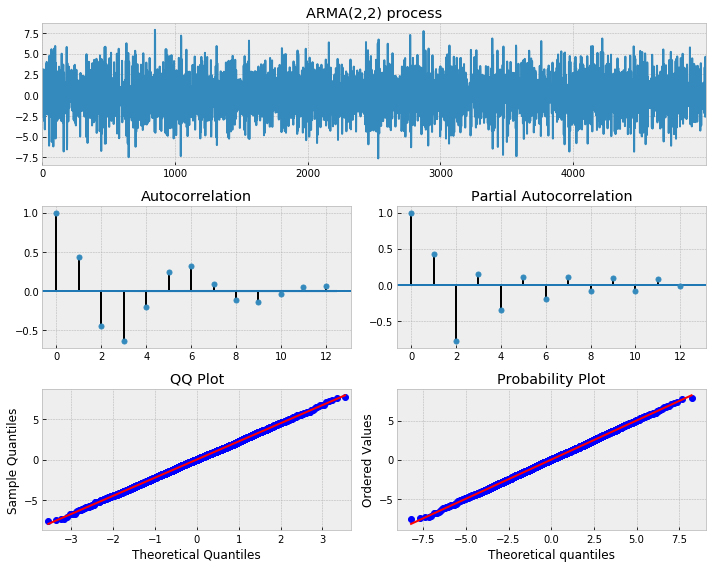

In [0]:
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [0]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


In [0]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 16754.26676 | order: (4, 4)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [0]:
best_mdl.predict()

In [0]:
data.head()

pickups
time                               
2018-01-01 00:00:00+00:00  231546.0
2018-01-02 00:00:00+00:00  233052.0
2018-01-03 00:00:00+00:00  261087.0
2018-01-04 00:00:00+00:00  119818.0
2018-01-05 00:00:00+00:00  259731.0

In [0]:
ts=data.groupby(["time"])["pickups"].sum()
ts.index=pd.date_range(start = '2018-01-01',end='2019-12-31', freq = 'D')
ts=ts.reset_index()
ts.head()

index   pickups
0 2018-01-01  231546.0
1 2018-01-02  233052.0
2 2018-01-03  261087.0
3 2018-01-04  119818.0
4 2018-01-05  259731.0

In [0]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = model.make_future_dataframe(periods = 365, freq = 'D')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [0]:
forecast.head()

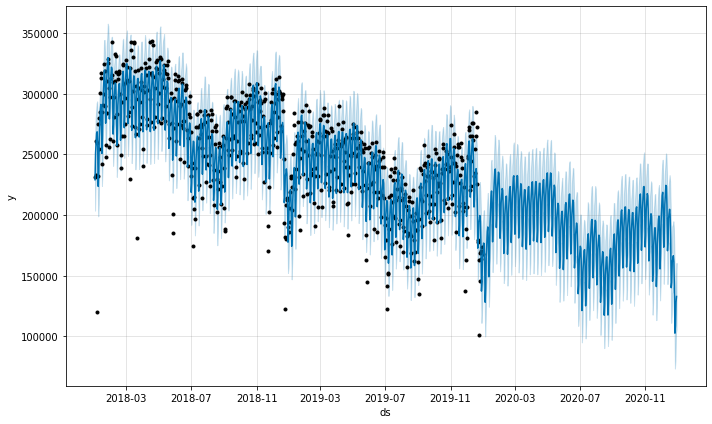

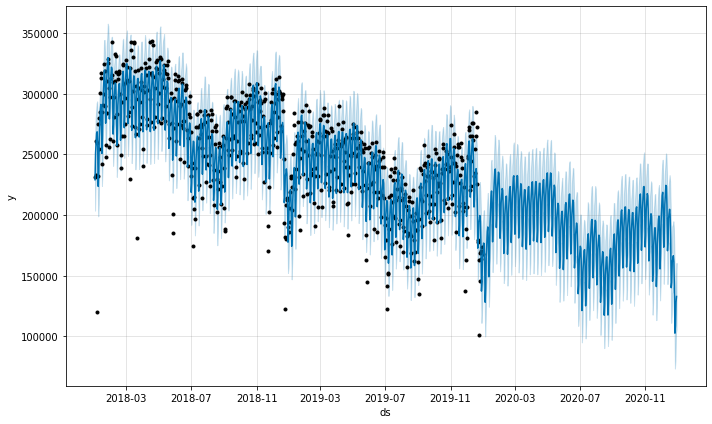

In [0]:
model.plot(forecast)

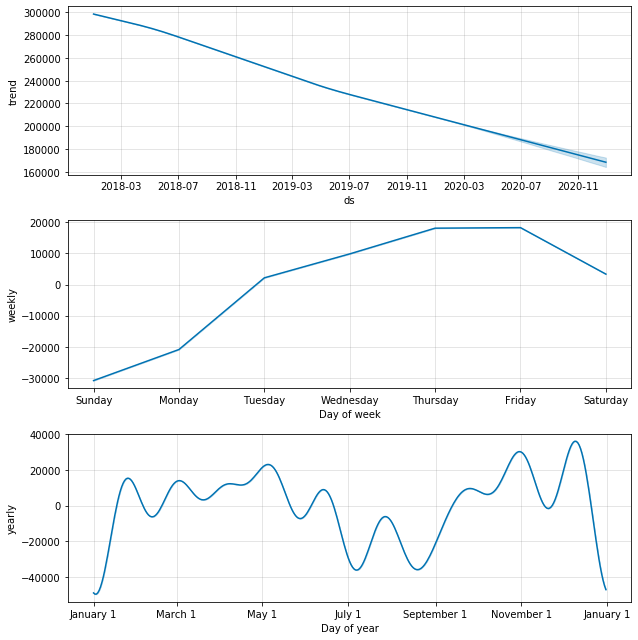

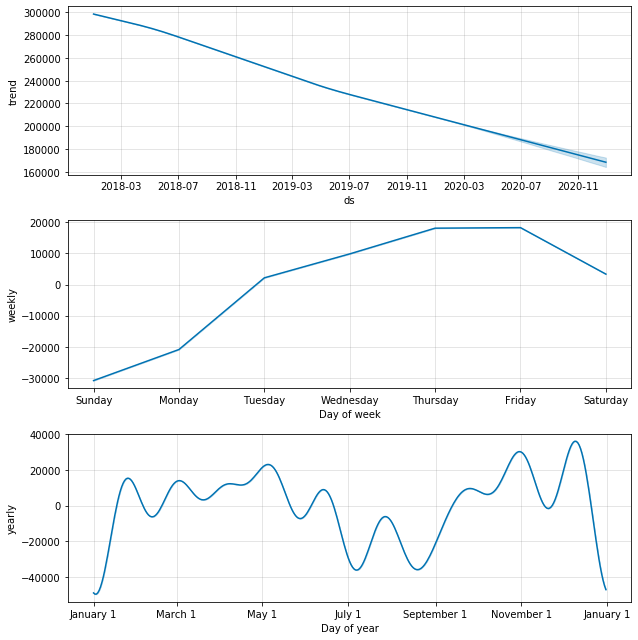

In [0]:
model.plot_components(forecast)

In [0]:
ts=df2.groupby(["time","zone_id"])["pickups"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

Different Try

In [0]:
data=df2

In [0]:
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum()

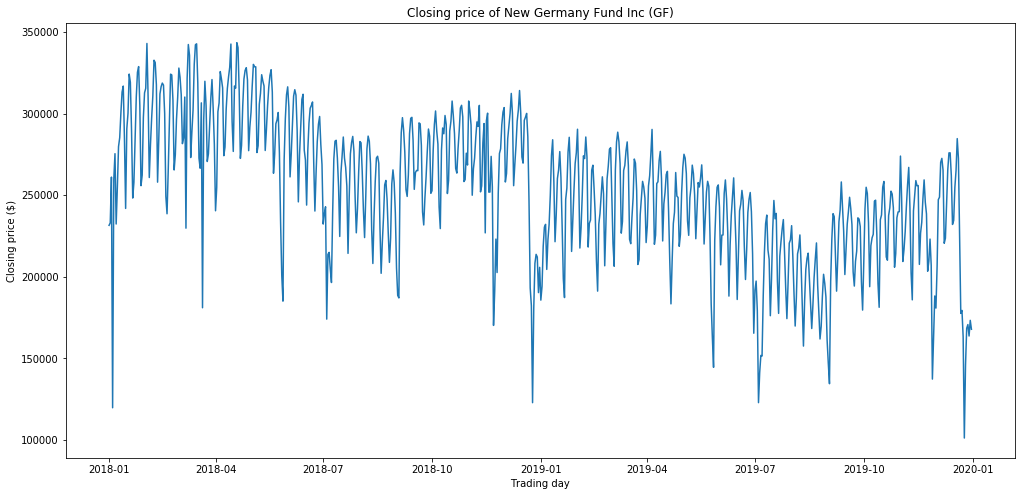

In [0]:
plt.figure(figsize=(17, 8))
plt.plot(data.pickups)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

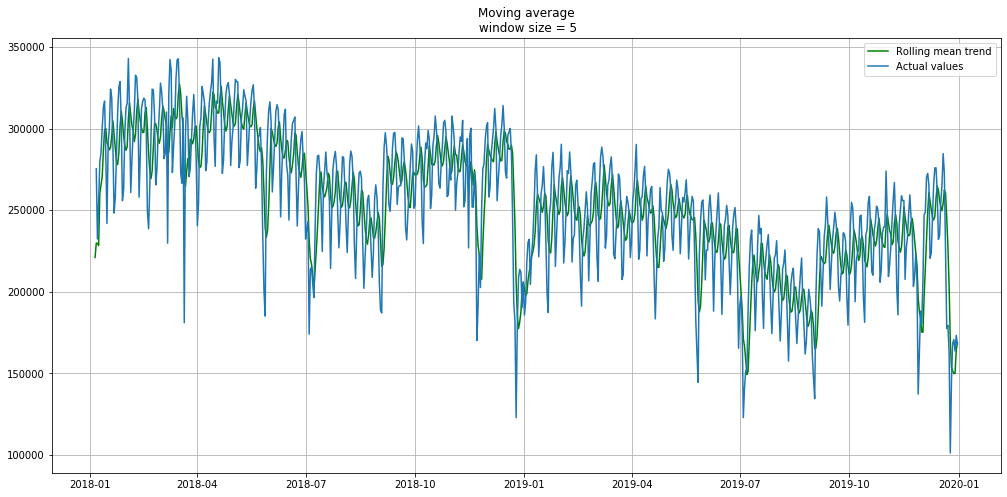

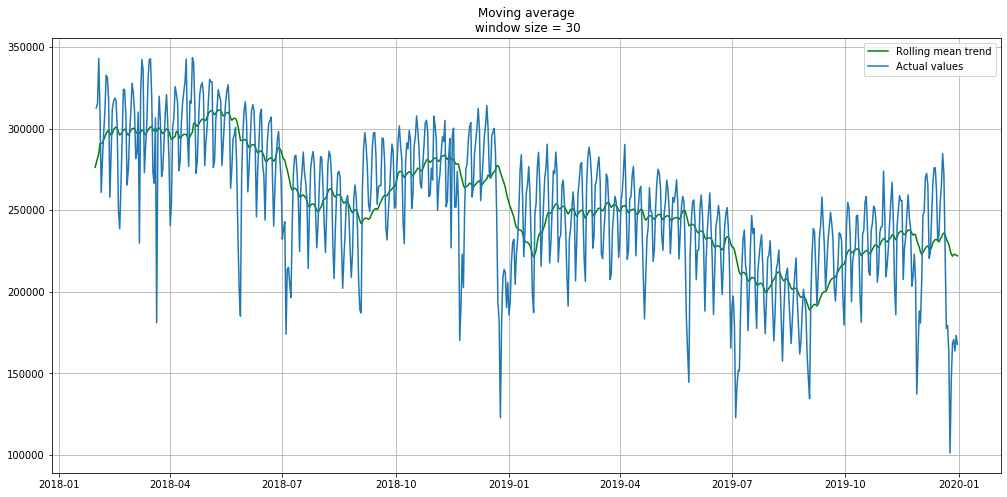

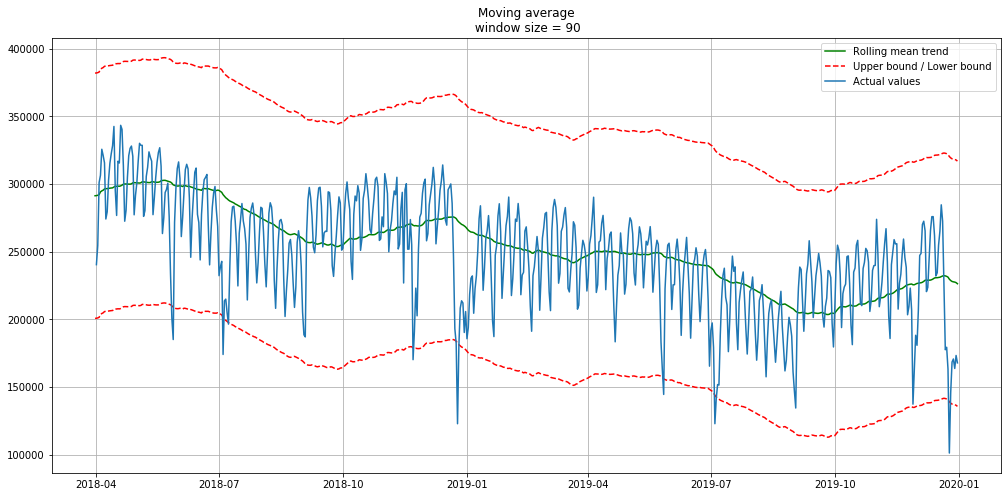

In [0]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.pickups, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.pickups, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.pickups, 90, plot_intervals=True)

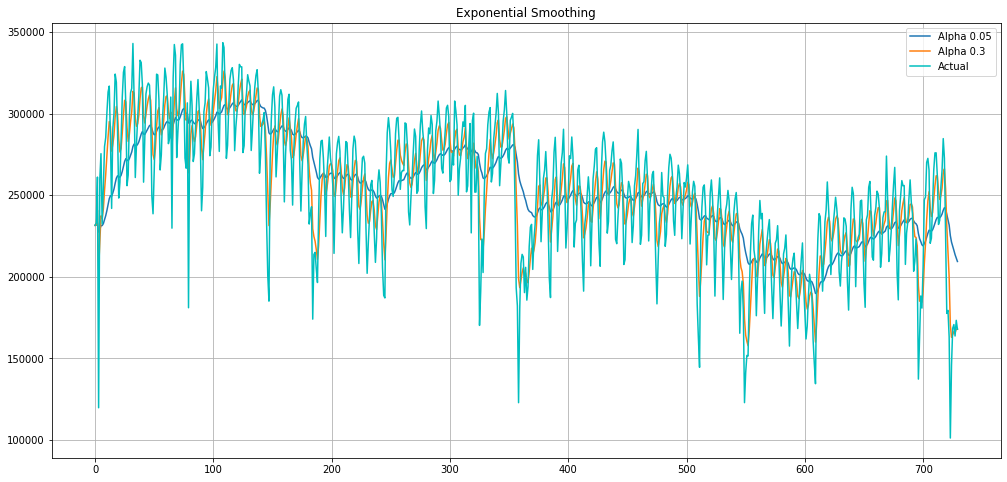

In [0]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.pickups, [0.05, 0.3])

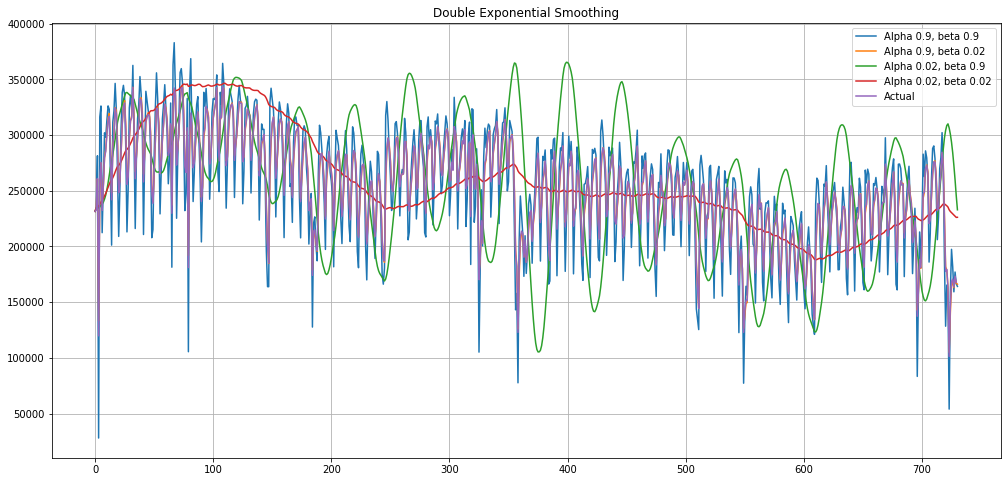

In [0]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.pickups, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [0]:
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



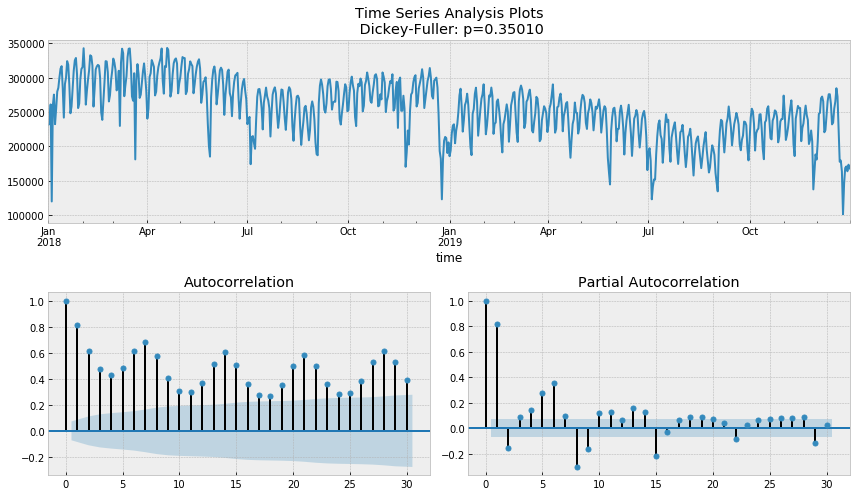

In [0]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.pickups, lags=30)

# Take the first difference to remove to make the process stationary


In [0]:
data_diff = data.pickups - data.pickups.shift(1)


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



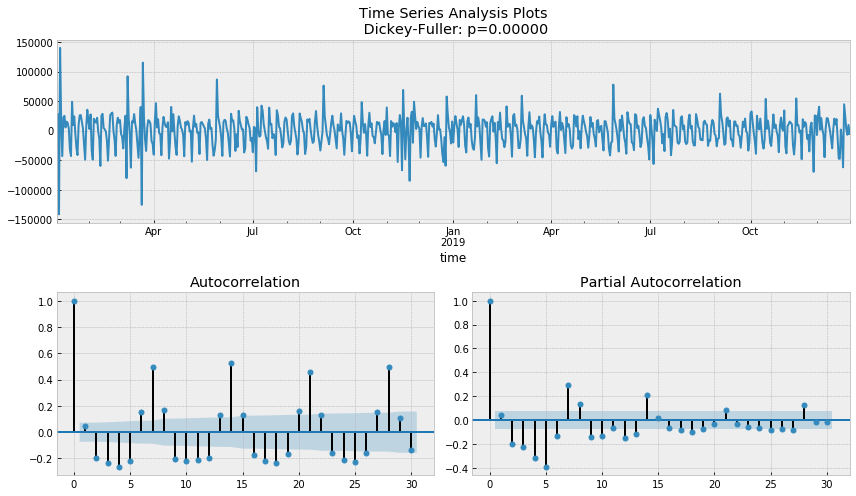

In [0]:
tsplot(data_diff[1:], lags=30)

In [0]:

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        
        try:
            print("hello")
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [0]:
from tqdm import tqdm_notebook
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [0]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [0]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [0]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [0]:
best_model = sm.tsa.statespace.SARIMAX(data.pickups, order=(1, d, 0),
                                       seasonal_order=(1, 2, 0, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                           pickups   No. Observations:                  730
Model:             SARIMAX(1, 1, 0)x(1, 2, 0, 5)   Log Likelihood               -8874.134
Date:                           Tue, 10 Mar 2020   AIC                          17754.268
Time:                                   05:23:10   BIC                          17768.001
Sample:                               01-01-2018   HQIC                         17759.570
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2474      0.061      4.035      0.000       0.127       0.368
ar.S.L5       -0.6258      0.037    -16.929

In [0]:
best_model

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



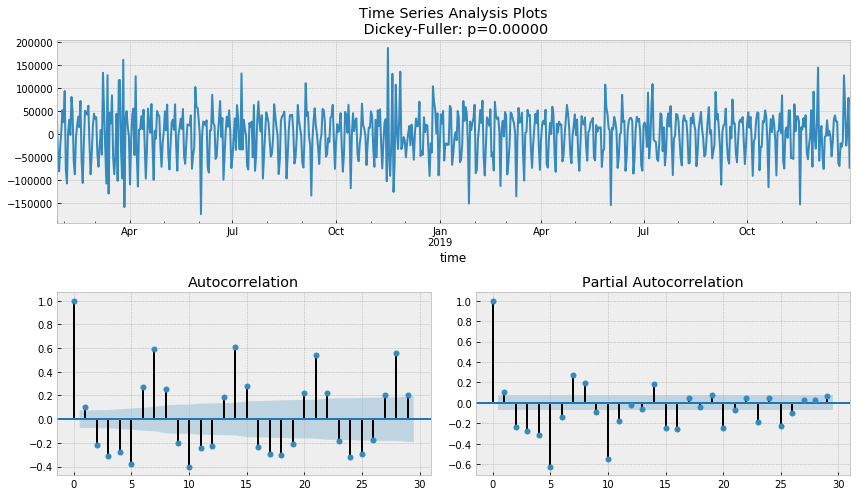

In [0]:
tsplot(best_model.resid[24+1:])

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

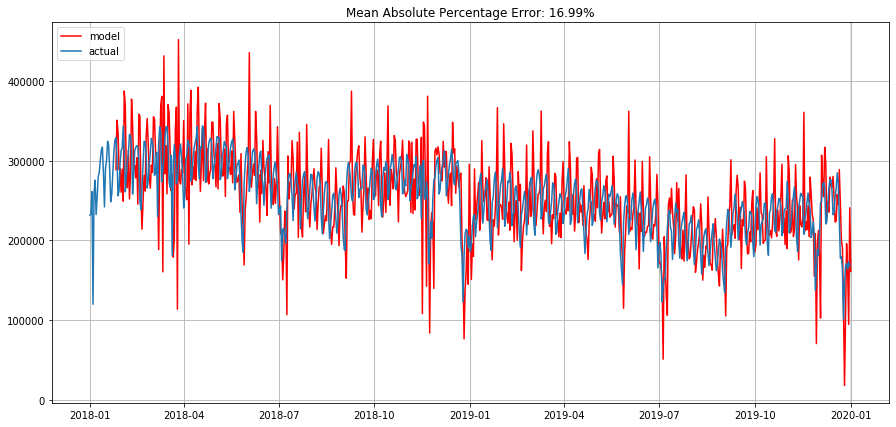

In [0]:
plotSARIMA(data, best_model, 0)

In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [0]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

In [0]:
importances = reg.feature_importances_

In [0]:
_ = plot_importance(reg, height=0.9)

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(reg, max_num_features=7, ax=ax)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

In [0]:
a=rf.predict(X_test)

In [0]:
import lightgbm as lgb
print("Fitting...")
parameters = gbm.fit( X_train, y_train )
print("Fitted...")